In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath('../../models/knn'))
from knn import KNNClassifier
from knn import Metrics

def load_data():
    data_path = os.path.abspath(os.path.join("1", "..", "..", "..", "data", "external", 'spotify.csv'))
    return pd.read_csv(data_path)

def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype.name != 'object':
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

def custom_label_encoder(series):
    unique_vals = series.unique()
    val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
    encoded = series.map(val_to_int)
    return encoded, val_to_int

def label_encode_columns(df, columns):
    label_encoders = {}
    for col in columns:
        df[col], encoder = custom_label_encoder(df[col])
        label_encoders[col] = encoder
    return df, label_encoders

def drop_unnecessary_columns(df):
    df.drop(columns=['track_id', 'track_name', 'Unnamed: 0', 'artists', 'album_name'], inplace=True, errors='ignore')
    return df

def encode_target_variable(df):
    df['track_genre'], genre_encoder = custom_label_encoder(df['track_genre'])
    return df, genre_encoder

def train_test_val_split(df, train_size=0.8, test_size=0.1):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(df))
    train_end = int(train_size * len(df))
    test_end = int(test_size * len(df)) + train_end
    
    train_indices = shuffled_indices[:train_end]
    test_indices = shuffled_indices[train_end:test_end]
    val_indices = shuffled_indices[test_end:]
    
    return df.iloc[train_indices], df.iloc[test_indices], df.iloc[val_indices]

def standardize(X_train, X_test, X_val, categorical_columns):
    num_columns = X_train.columns.difference(categorical_columns)
    mean = X_train[num_columns].mean(axis=0)
    std = X_train[num_columns].std(axis=0)
    
    X_train[num_columns] = (X_train[num_columns] - mean) / std
    X_test[num_columns] = (X_test[num_columns] - mean) / std
    X_val[num_columns] = (X_val[num_columns] - mean) / std
    
    return X_train, X_test, X_val

df = load_data()
df = impute_missing_values(df)
df, label_encoders = label_encode_columns(df, ['explicit'])
df = drop_unnecessary_columns(df)
df, genre_encoder = encode_target_variable(df)
df_train, df_test, df_val = train_test_val_split(df)

X_train = df_train.drop(columns=['track_genre'])
X_test = df_test.drop(columns=['track_genre'])
X_val = df_val.drop(columns=['track_genre'])

y_train = df_train['track_genre']
y_test = df_test['track_genre']
y_val = df_val['track_genre']

X_train_scaled, X_test_scaled, X_val_scaled = standardize(X_train, X_test, X_val, ['explicit'])

Train MSE: 0.07419461990473017
Test MSE: 0.07542965122453166
Train MAE: 0.17904922664285924
Test MAE: 0.18082781417489288
Train R2: 0.8723319923586893
Test R2: 0.8704976669367465


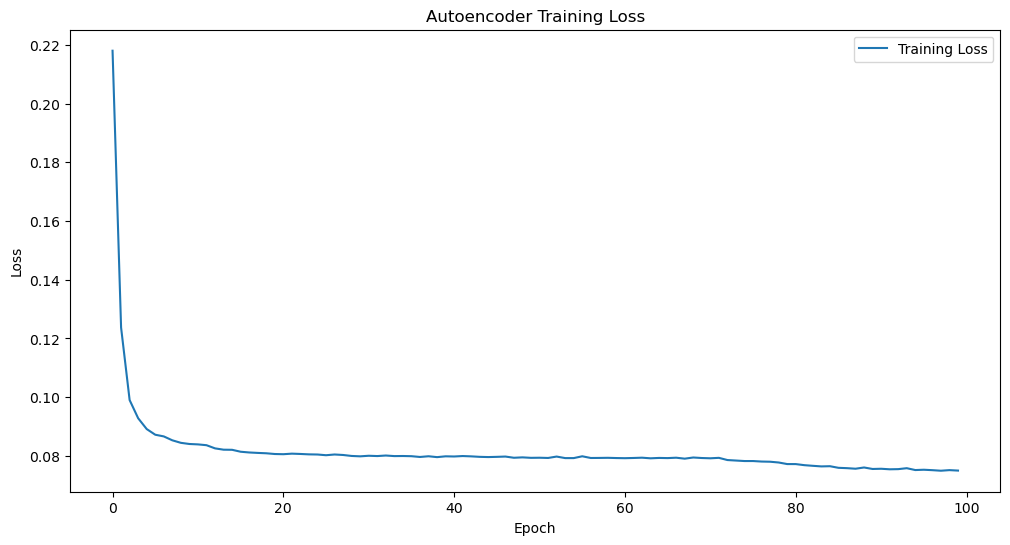

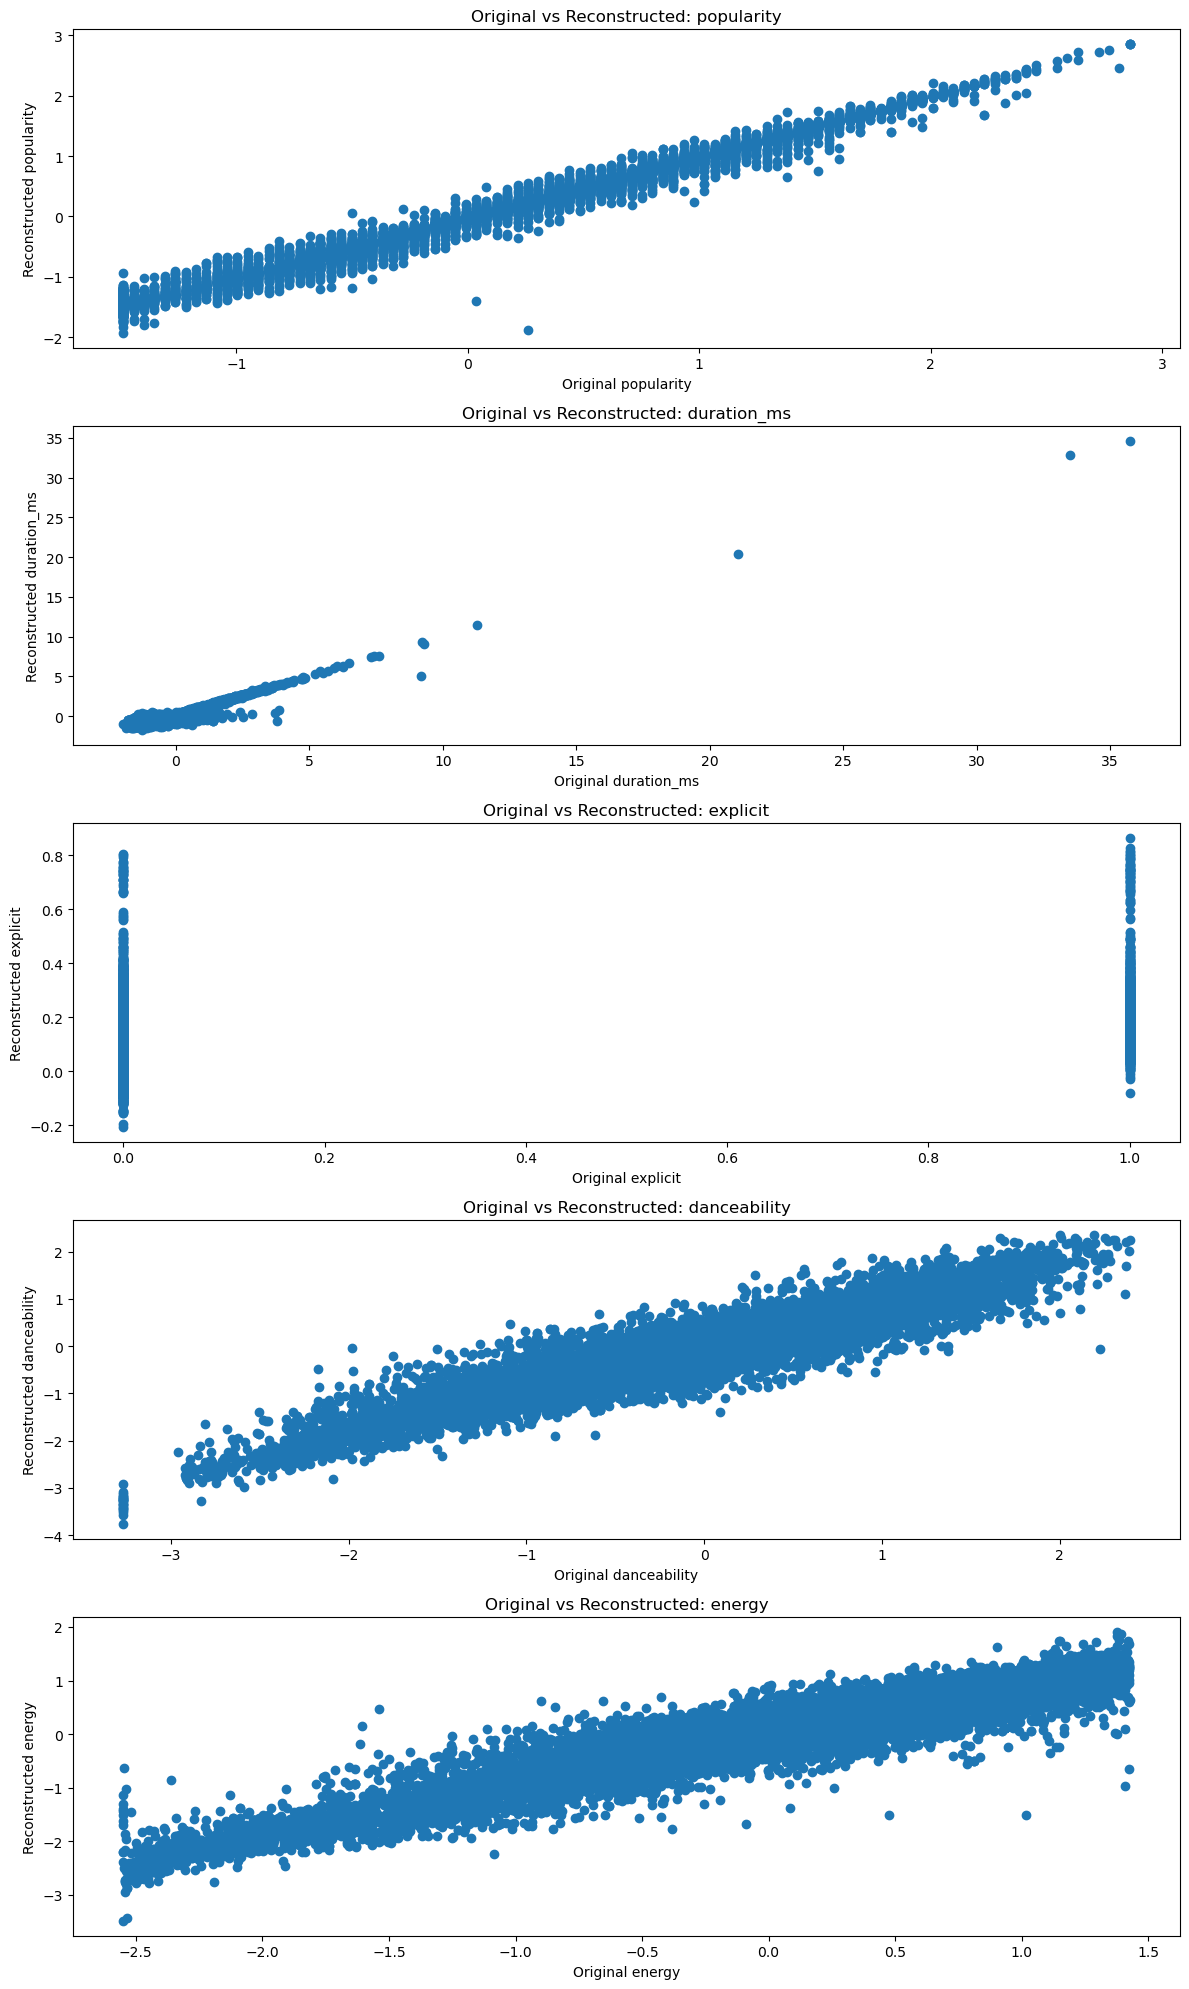

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os,sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  

from models.MLP.MLP import MLP_Reg
from models.AutoEncoder.AutoEncoder import AutoEncoder

X_train = X_train_scaled
X_test = X_test_scaled

architecture = [
    {"units": 20, "activation": "relu"},
    {"units": 10, "activation": "relu"},
    {"units": 20, "activation": "relu"}
]

autoencoder = AutoEncoder(input_dim=X_train.shape[1], architecture=architecture, 
                          learning_rate=0.01, epochs=100, batch_size=32)

training_errors = autoencoder.fit(X_train)

latent_train = autoencoder.get_latent(X_train)
latent_test = autoencoder.get_latent(X_test)

reconstructed_train = autoencoder.reconstruct(X_train)
reconstructed_test = autoencoder.reconstruct(X_test)

train_mse = mean_squared_error(X_train, reconstructed_train)
test_mse = mean_squared_error(X_test, reconstructed_test)
train_mae = mean_absolute_error(X_train, reconstructed_train)
test_mae = mean_absolute_error(X_test, reconstructed_test)
train_r2 = r2_score(X_train, reconstructed_train)
test_r2 = r2_score(X_test, reconstructed_test)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

plt.figure(figsize=(12, 6))
plt.plot(training_errors, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()


n_features = min(5, X_test.shape[1])
fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
for i in range(n_features):
    axes[i].scatter(X_test.iloc[:, i], reconstructed_test[:, i])
    axes[i].set_xlabel(f'Original {X_test.columns[i]}')
    axes[i].set_ylabel(f'Reconstructed {X_test.columns[i]}')
    axes[i].set_title(f'Original vs Reconstructed: {X_test.columns[i]}')
plt.tight_layout()
plt.show()

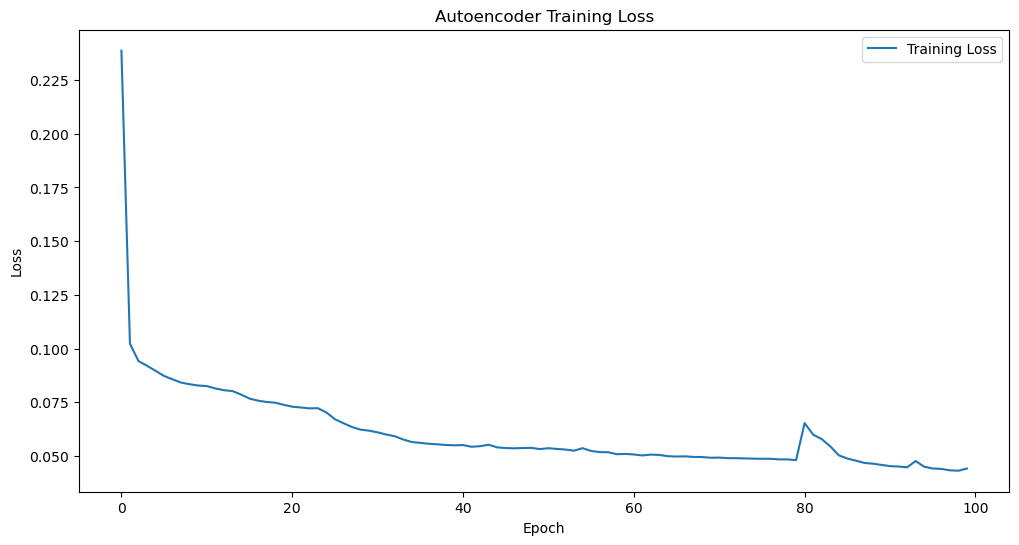

Original shape: (91200, 15)
Reduced shape: (91200, 9)
Train MSE: 0.05237875614032062
Test MSE: 0.05310546740315962
Train R2: 0.8937088168166328
Test R2: 0.8923706762685729


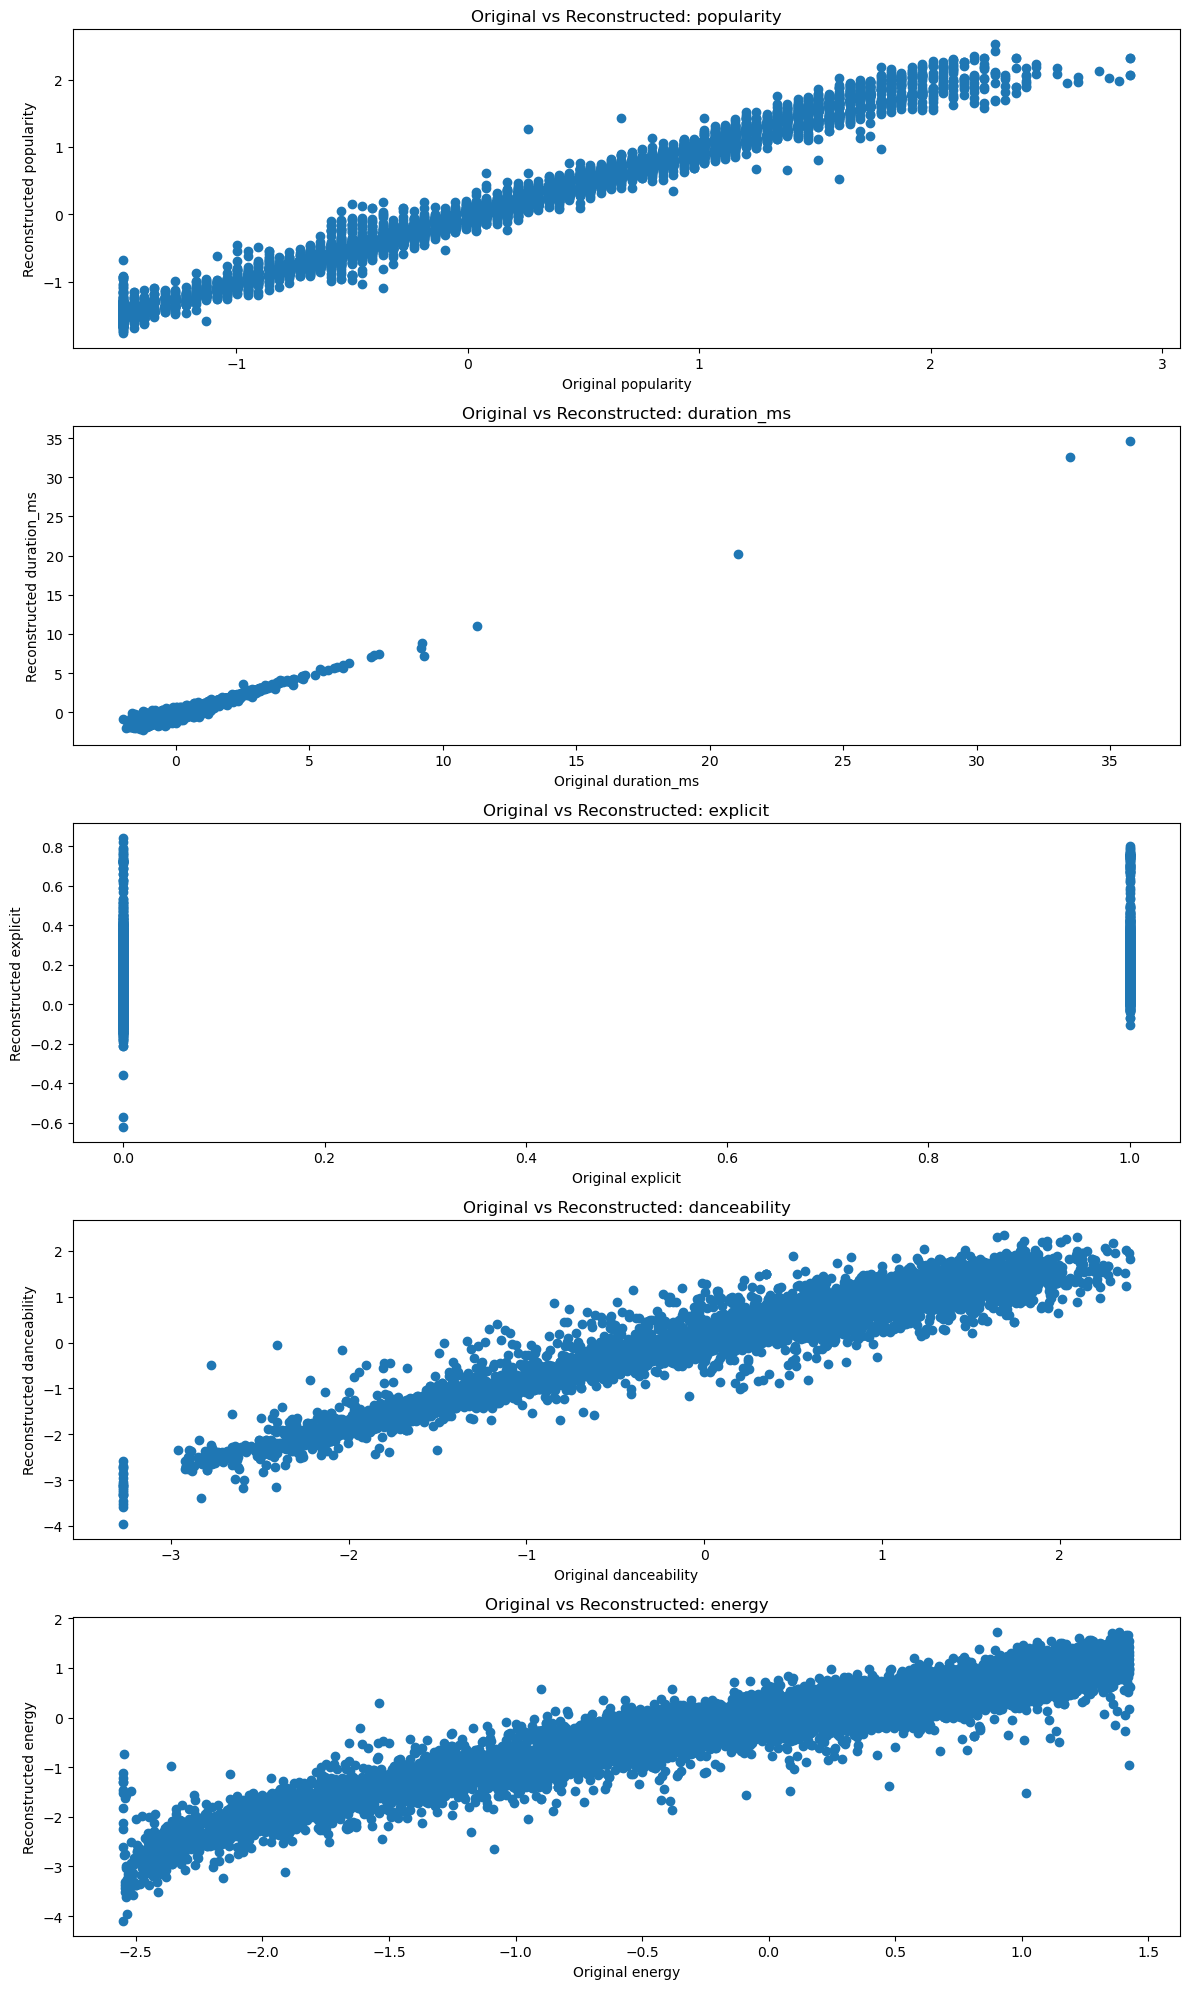

In [5]:
def reduce_dimensions(X_train, X_test, X_val, target_dimensions=9, learning_rate=0.01, epochs=100, batch_size=32):
    """
    Reduce the dimensions of the input data using an AutoEncoder.
    """
    input_dim = X_train.shape[1]
    architecture = [
        {"units": 20, "activation": "relu"},
        {"units": target_dimensions, "activation": "relu"},
        {"units": 20, "activation": "relu"}
    ]
    
    autoencoder = AutoEncoder(input_dim=input_dim, architecture=architecture, 
                              learning_rate=learning_rate, epochs=epochs, 
                              batch_size=batch_size)
    
    training_errors = autoencoder.fit(X_train)
    
    latent_train = autoencoder.get_latent(X_train)
    latent_test = autoencoder.get_latent(X_test)
    latent_val = autoencoder.get_latent(X_val)
    
    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.plot(training_errors, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training Loss')
    plt.legend()
    plt.show()
    
    return latent_train, latent_test, latent_val, autoencoder

df = load_data()
df = impute_missing_values(df)
df, label_encoders = label_encode_columns(df, ['explicit'])
df = drop_unnecessary_columns(df)
df, genre_encoder = encode_target_variable(df)
df_train, df_test, df_val = train_test_val_split(df)

X_train = df_train.drop(columns=['track_genre'])
X_test = df_test.drop(columns=['track_genre'])
X_val = df_val.drop(columns=['track_genre'])

y_train = df_train['track_genre']
y_test = df_test['track_genre']
y_val = df_val['track_genre']

X_train_scaled, X_test_scaled, X_val_scaled = standardize(X_train, X_test, X_val, ['explicit'])

X_train_reduced, X_test_reduced, X_val_reduced, autoencoder = reduce_dimensions(X_train_scaled, X_test_scaled, X_val_scaled)

print("Original shape:", X_train_scaled.shape)
print("Reduced shape:", X_train_reduced.shape)

reconstructed_train = autoencoder.reconstruct(X_train_scaled)
reconstructed_test = autoencoder.reconstruct(X_test_scaled)

train_mse = mean_squared_error(X_train_scaled, reconstructed_train)
test_mse = mean_squared_error(X_test_scaled, reconstructed_test)
train_r2 = r2_score(X_train_scaled, reconstructed_train)
test_r2 = r2_score(X_test_scaled, reconstructed_test)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Visualize original vs reconstructed features
n_features = min(5, X_test_scaled.shape[1])
fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
for i in range(n_features):
    axes[i].scatter(X_test_scaled.iloc[:, i], reconstructed_test[:, i])
    axes[i].set_xlabel(f'Original {X_test_scaled.columns[i]}')
    axes[i].set_ylabel(f'Reconstructed {X_test_scaled.columns[i]}')
    axes[i].set_title(f'Original vs Reconstructed: {X_test_scaled.columns[i]}')
plt.tight_layout()
plt.show()

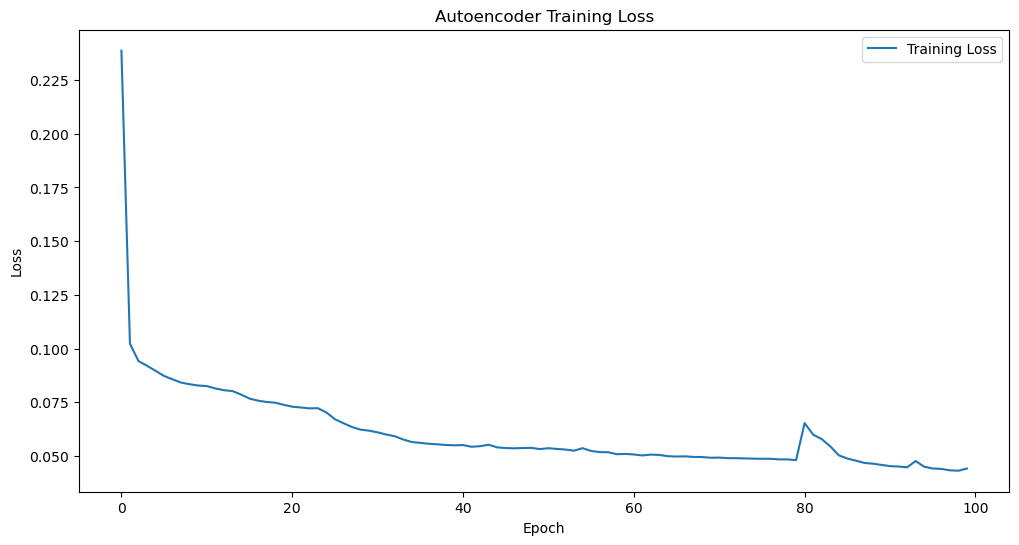

k     Distance     Acc        Prec       Recall     F1         Time (s)  
23    manhattan    0.2024     0.1010     0.0926     0.0966     118.3068  


In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.abspath('../../models/knn'))
from knn import KNNClassifier
from knn import Metrics

from sklearn.neighbors import KNeighborsClassifier
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  
import matplotlib.pyplot as plt
from models.PCA.PCA import PCA
from models.Kmeans.Kmeans import Kmeans

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
# from sklearn.decomposition import PCA

sys.path.append(os.path.abspath('../../models/knn'))
from knn import KNNClassifier
from knn import Metrics

def load_data():
    data_path = os.path.abspath(os.path.join("1", "..", "..", "..", "data", "external", 'spotify.csv'))
    return pd.read_csv(data_path)

def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype.name != 'object':
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

def custom_label_encoder(series):
    unique_vals = series.unique()
    val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
    encoded = series.map(val_to_int)
    return encoded, val_to_int

def label_encode_columns(df, columns):
    label_encoders = {}
    for col in columns:
        df[col], encoder = custom_label_encoder(df[col])
        label_encoders[col] = encoder
    return df, label_encoders

def drop_unnecessary_columns(df):
    df.drop(columns=['track_id', 'track_name', 'Unnamed: 0', 'artists', 'album_name'], inplace=True, errors='ignore')
    return df

def encode_target_variable(df):
    df['track_genre'], genre_encoder = custom_label_encoder(df['track_genre'])
    return df, genre_encoder

def train_test_val_split(df, train_size=0.8, test_size=0.1):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(df))
    train_end = int(train_size * len(df))
    test_end = int(test_size * len(df)) + train_end
    
    train_indices = shuffled_indices[:train_end]
    test_indices = shuffled_indices[train_end:test_end]
    val_indices = shuffled_indices[test_end:]
    
    return df.iloc[train_indices], df.iloc[test_indices], df.iloc[val_indices]

def standardize(X_train, X_test, X_val, categorical_columns):
    num_columns = X_train.columns.difference(categorical_columns)
    mean = X_train[num_columns].mean(axis=0)
    std = X_train[num_columns].std(axis=0)
    
    X_train[num_columns] = (X_train[num_columns] - mean) / std
    X_test[num_columns] = (X_test[num_columns] - mean) / std
    X_val[num_columns] = (X_val[num_columns] - mean) / std
    
    return X_train, X_test, X_val

def apply_pca(X_train, X_test, X_val, n_components=7):
    
    pca = PCA(n_components=n_components)
    
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    
    # pca.fit(X_test)
    X_test_pca =  pca.transform(X_test)
    
    # pca.fit(X_val)
    X_val_pca = pca.transform(X_val)
    
    # X_train_pca = pca.fit_transform(X_train)
    # X_test_pca = pca.transform(X_test)
    # X_val_pca = pca.transform(X_val)
    
    return X_train_pca, X_test_pca, X_val_pca

def train_data(X_train, y_train, X_val, y_val):
    k_values = [23]
    distance_metrics = ['manhattan']
    
    results = []

    for k in k_values:
        for distance_metric in distance_metrics:
            knn = KNNClassifier(k=k, distance_metric=distance_metric)
            knn.fit(X_train, y_train)
            
            # Measure inference time
            start_time = time.time()
            y_pred_val = knn.predict(X_val)
            end_time = time.time()
            inference_time = end_time - start_time
            
            accuracy = Metrics.accuracy(y_val, y_pred_val)
            precision = Metrics.precision(y_val, y_pred_val)
            recall = Metrics.recall(y_val, y_pred_val)
            f1_score = Metrics.f1_score(y_val, y_pred_val)

            results.append((k, distance_metric, accuracy, precision, recall, f1_score, inference_time))

    results.sort(key=lambda x: x[2], reverse=True)
    return results

df = load_data()
df = impute_missing_values(df)
df, label_encoders = label_encode_columns(df, ['explicit'])
df = drop_unnecessary_columns(df)
df, genre_encoder = encode_target_variable(df)
df_train, df_test, df_val = train_test_val_split(df)

X_train = df_train.drop(columns=['track_genre'])
X_test = df_test.drop(columns=['track_genre'])
X_val = df_val.drop(columns=['track_genre'])

y_train = df_train['track_genre']
y_test = df_test['track_genre']
y_val = df_val['track_genre']

X_train_scaled, X_test_scaled, X_val_scaled = standardize(X_train, X_test, X_val, ['explicit'])

X_train_pca, X_test_pca, X_val_pca,autoencoder = reduce_dimensions(X_train_scaled, X_test_scaled, X_val_scaled)

results = train_data(X_train_pca, y_train.values, X_val_pca, y_val.values)

print(f"{'k':<5} {'Distance':<12} {'Acc':<10} {'Prec':<10} {'Recall':<10} {'F1':<10} {'Time (s)':<10}")
for k, distance_metric, accuracy, precision, recall, f1, inference_time in results[:10]:
    print(f"{k:<5} {distance_metric:<12} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {inference_time:<10.4f}")
    

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.abspath('../../models/knn'))
from knn import KNNClassifier
from knn import Metrics

from sklearn.neighbors import KNeighborsClassifier
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  
import matplotlib.pyplot as plt
from models.PCA.PCA import PCA
from models.Kmeans.Kmeans import Kmeans

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
# from sklearn.decomposition import PCA

sys.path.append(os.path.abspath('../../models/knn'))
from knn import KNNClassifier
from knn import Metrics

import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))  
from models.MLP.MLP import MLP_SingleLabelClassifier,MLP_MultiLabelClassifier,MLP


def load_data():
    data_path = os.path.abspath(os.path.join("1", "..", "..", "..", "data", "external", 'spotify.csv'))
    return pd.read_csv(data_path)

def impute_missing_values(df):
    for col in df.columns:
        if df[col].dtype.name != 'object':
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

def custom_label_encoder(series):
    unique_vals = series.unique()
    val_to_int = {val: idx for idx, val in enumerate(unique_vals)}
    encoded = series.map(val_to_int)
    return encoded, val_to_int

def label_encode_columns(df, columns):
    label_encoders = {}
    for col in columns:
        df[col], encoder = custom_label_encoder(df[col])
        label_encoders[col] = encoder
    return df, label_encoders

def drop_unnecessary_columns(df):
    df.drop(columns=['track_id', 'track_name', 'Unnamed: 0', 'artists', 'album_name'], inplace=True, errors='ignore')
    return df

def encode_target_variable(df):
    df['track_genre'], genre_encoder = custom_label_encoder(df['track_genre'])
    return df, genre_encoder

def train_test_val_split(df, train_size=0.8, test_size=0.1):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(df))
    train_end = int(train_size * len(df))
    test_end = int(test_size * len(df)) + train_end
    
    train_indices = shuffled_indices[:train_end]
    test_indices = shuffled_indices[train_end:test_end]
    val_indices = shuffled_indices[test_end:]
    
    return df.iloc[train_indices], df.iloc[test_indices], df.iloc[val_indices]

def standardize(X_train, X_test, X_val, categorical_columns):
    num_columns = X_train.columns.difference(categorical_columns)
    mean = X_train[num_columns].mean(axis=0)
    std = X_train[num_columns].std(axis=0)
    
    X_train[num_columns] = (X_train[num_columns] - mean) / std
    X_test[num_columns] = (X_test[num_columns] - mean) / std
    X_val[num_columns] = (X_val[num_columns] - mean) / std
    
    return X_train, X_test, X_val

def apply_pca(X_train, X_test, X_val, n_components=7):
    
    pca = PCA(n_components=n_components)
    
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    
    # pca.fit(X_test)
    X_test_pca =  pca.transform(X_test)
    
    # pca.fit(X_val)
    X_val_pca = pca.transform(X_val)
    
    # X_train_pca = pca.fit_transform(X_train)
    # X_test_pca = pca.transform(X_test)
    # X_val_pca = pca.transform(X_val)
    
    return X_train_pca, X_test_pca, X_val_pca

def train_data(X_train, y_train, X_val, y_val):
    k_values = [23]
    distance_metrics = ['manhattan']
    
    results = []

    for k in k_values:
        for distance_metric in distance_metrics:
            num_classes = len(np.unique(y_train))

            start_time = time.time()
            mlp = MLP_SingleLabelClassifier(input_size=X_train.shape[1], hidden_layers=[32, 64], output_size=num_classes,
                    learning_rate=0.001, activation='tanh', optimizer='mini_batch_gd',
                    batch_size=32, epochs=100)
            
            mlp.fit(X_train, y_train,validation=False)
            
            # Measure inference time
            y_pred_val = mlp.predict(X_val)
            end_time = time.time()
            inference_time = end_time - start_time
            
            accuracy = Metrics.accuracy(y_val, y_pred_val)
            precision = Metrics.precision(y_val, y_pred_val)
            recall = Metrics.recall(y_val, y_pred_val)
            f1_score = Metrics.f1_score(y_val, y_pred_val)

            results.append((k, distance_metric, accuracy, precision, recall, f1_score, inference_time))

    results.sort(key=lambda x: x[2], reverse=True)
    return results

df = load_data()
df = impute_missing_values(df)
df, label_encoders = label_encode_columns(df, ['explicit'])
df = drop_unnecessary_columns(df)
df, genre_encoder = encode_target_variable(df)
df_train, df_test, df_val = train_test_val_split(df)

X_train = df_train.drop(columns=['track_genre'])
X_test = df_test.drop(columns=['track_genre'])
X_val = df_val.drop(columns=['track_genre'])

y_train = df_train['track_genre']
y_test = df_test['track_genre']
y_val = df_val['track_genre']

X_train_scaled, X_test_scaled, X_val_scaled = standardize(X_train, X_test, X_val, ['explicit'])

X_train_pca = X_train_scaled
X_test_pca = X_test_scaled
X_val_pca = X_val_scaled

results = train_data(X_train_pca, y_train.values, X_val_pca, y_val.values)

print(f"{'k':<5} {'Distance':<12} {'Acc':<10} {'Prec':<10} {'Recall':<10} {'F1':<10} {'Time (s)':<10}")
for k, distance_metric, accuracy, precision, recall, f1, inference_time in results[:10]:
    print(f"{k:<5} {distance_metric:<12} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {inference_time:<10.4f}")
    

/tmp/ipykernel_27723/341988368.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_27723/341988368.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

k     Distance     Acc        Prec       Recall     F1         Time (s)  
23    manhattan    0.2261     0.1618     0.1019     0.1250     187.9299  
